In [1]:
import sklearn
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold,train_test_split,cross_val_score,cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 6)
pd.options.display.max_rows = 10

In [2]:
df = pd.read_csv('sentimented_dataset.csv')
df

,group_url,from_id,owner_id,text,label
0,samsung.galaxy_a,-24240100,-24240100,Стала известна точная дата выхода Galaxy S21\r...,0
1,samsung.galaxy_a,563762178,-24240100,Можно ли поставить гугл камеру на j8?,0
2,samsung.galaxy_a,-24240100,-24240100,Инсайдер раскрыл технические характеристики Sn...,0
3,samsung.galaxy_a,-24240100,-24240100,Samsung представил новый сенсор Vizion 33D для...,0
4,samsung.galaxy_a,40969143,-24240100,Здравствуйте. Где можно скачать гугл камеру? А71,0
...,...,...,...,...,...
7890,ru_oppo,189630066,-139809093,Китайский бренд Oppo готовит к релизу свои топ...,0
7891,ru_oppo,375540195,-139809093,OPPO брат естественных условиях,0
7892,ru_oppo,189630066,-139809093,Представители компании Oppo вчера сообщили о т...,0
7893,ru_oppo,189630066,-139809093,Сегодня компания Oppo заявила о 3 млн смартфон...,0


In [3]:
df.groupby('group_url').count()[['from_id']]

,from_id
group_url,
huaweip20,1981
kupit_iphone_v_moskve,1153
ru_oppo,211
rumicomrussia,2452
samsung.galaxy_a,2098


In [4]:
from sklearn.utils import resample

balanced = pd.concat([resample(df[df.group_url == 'huaweip20'], n_samples=1000),
           resample(df[df.group_url == 'kupit_iphone_v_moskve'], n_samples=1000),
           resample(df[df.group_url == 'rumicomrussia'], n_samples=1000),
           resample(df[df.group_url == 'samsung.galaxy_a'], n_samples=1000),
           resample(df[df.group_url == 'ru_oppo'], n_samples=1000)], ignore_index=True)

balanced

,group_url,from_id,owner_id,text,label
0,huaweip20,179690330,-164458686,Господа есть вопрос к владельцам Р20 ! Последн...,0
1,huaweip20,278106536,-164458686,Как добавить фото контакта?,0
2,huaweip20,176534108,-164458686,Дождался)))),0
3,huaweip20,279139418,-164458686,P20 PRO🔱,0
4,huaweip20,76762008,-164458686,Народ появилась возможность сменить свой HUAWE...,0
...,...,...,...,...,...
4995,ru_oppo,189630066,-139809093,"Дисплей новинки занимает 92,25% площади фронта...",0
4996,ru_oppo,224126187,-139809093,Сегодня приедит oppo realmi 3 pro кто пользует...,0
4997,ru_oppo,551644613,-139809093,Как разблокировать оппо a1k,0
4998,ru_oppo,260431986,-139809093,Как вам оппо рх17нео?,0


In [58]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
balanced['label_cat'] = le.fit_transform(balanced.group_url)
balanced

,group_url,from_id,owner_id,text,label,label_cat
0,huaweip20,179690330,-164458686,Господа есть вопрос к владельцам Р20 ! Последн...,0,0
1,huaweip20,278106536,-164458686,Как добавить фото контакта?,0,0
2,huaweip20,176534108,-164458686,Дождался)))),0,0
3,huaweip20,279139418,-164458686,P20 PRO🔱,0,0
4,huaweip20,76762008,-164458686,Народ появилась возможность сменить свой HUAWE...,0,0
...,...,...,...,...,...,...
4995,ru_oppo,189630066,-139809093,"Дисплей новинки занимает 92,25% площади фронта...",0,2
4996,ru_oppo,224126187,-139809093,Сегодня приедит oppo realmi 3 pro кто пользует...,0,2
4997,ru_oppo,551644613,-139809093,Как разблокировать оппо a1k,0,2
4998,ru_oppo,260431986,-139809093,Как вам оппо рх17нео?,0,2


In [59]:
import re
from nltk.stem.snowball import SnowballStemmer

def cleaning_data(code_data):
    text = code_data
    text = text.replace('(<br/>)', '')
    text = text.replace('(<a).*(>).*(</a>)', '')
    text = text.replace('(&amp)', '')
    text = text.replace('(&gt)', '')
    text = text.replace('(&lt)', '')
    text = text.replace('(\xa0)', ' ')
    text = filtering(text)
    #text = stemmering(text)
    return text.strip()

def filtering(text):
    stripped = re.sub('[^a-zA-Z, ^А-Я,а-я]', ' ', str(text).replace('-', ''))
    stripped = re.sub('_', '', stripped)
    stripped = re.sub('\s+', ' ', stripped)
    return str(stripped).lower()

def stemmering(text):
    stemmer = SnowballStemmer("russian")
    return ' '.join([stemmer.stem(word) for word in text.split(' ')])

In [62]:
X = pd.DataFrame(list(map(cleaning_data, balanced.text)))[0]
y = balanced.label_cat
X

0       господа есть вопрос к владельцам р последний п...
1                              как добавить фото контакта
2                                                дождался
3                                                   p pro
4       народ появилась возможность сменить свой huawe...
                              ...                        
4995    дисплей новинки занимает , площади фронтальной...
4996    сегодня приедит oppo realmi pro кто пользуется...
4997                          как разблокировать оппо a k
4998                                  как вам оппо рх нео
4999    куплю экран на орро f черный где можно покупат...
Name: 0, Length: 5000, dtype: object

In [63]:
y = y[(X != '').values]
X = X[(X != '').values]

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(len(X_train))
print(len(X_test))

3973
994


In [65]:
from nltk.corpus import stopwords

vectorizer = TfidfVectorizer(lowercase=True, sublinear_tf=True, smooth_idf=True)
x_train_tf = vectorizer.fit_transform(X_train)
x_test_tf = vectorizer.transform(X_test)
print(x_train_tf.shape)

(3973, 12761)


In [66]:
import itertools

def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='Greens'):
    df = pd.DataFrame(classificationReport).T.iloc[:,:3]
    df.style.background_gradient(cmap='viridis',
                             subset=pd.IndexSlice['0':'9', :'f1-score'])
    return df

In [67]:
model = RandomForestClassifier()
model.fit(x_train_tf.toarray(), y_train)

predictions = model.predict(x_test_tf.toarray())

c:\users\yelzha\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [69]:
le.classes_

array(['huaweip20', 'kupit_iphone_v_moskve', 'ru_oppo', 'rumicomrussia',
       'samsung.galaxy_a'], dtype=object)

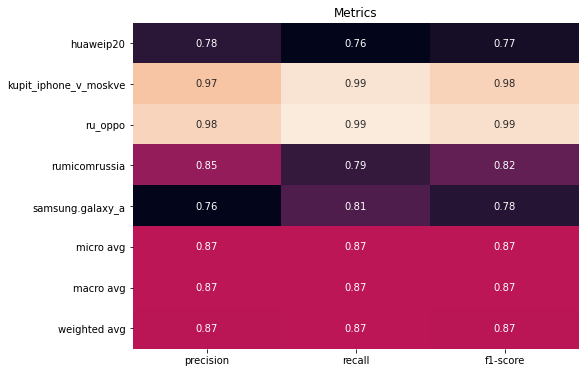

In [70]:
sns.heatmap(plot_classification_report(classification_report(y_test, predictions, output_dict=True, target_names=le.classes_)),
            square=False, annot=True, cbar=False)
plt.title('Metrics')
plt.show()

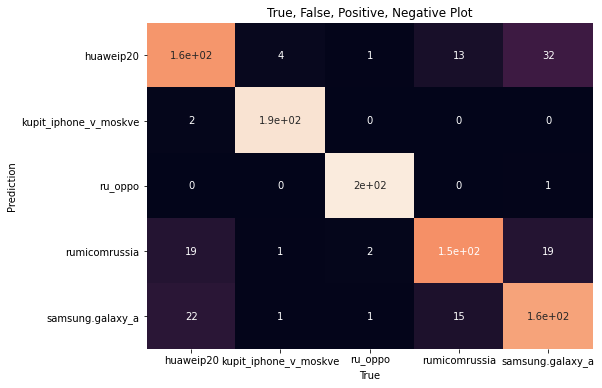

In [73]:
sns.heatmap(confusion_matrix(y_test, predictions), square=False, annot=True, cbar=False,
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('True, False, Positive, Negative Plot')
plt.xlabel('True')
plt.ylabel('Prediction')
plt.show()

In [92]:
def sequentialGet(text):
    vectored = vectorizer.transform([text])
    predictions_proba = model.predict_proba(vectored.toarray())[0]
    result = {}
    for i, j in zip(le.classes_, predictions_proba):
        result[i] = j
    return {k: v for k, v in sorted(result.items(), key=lambda item: item[1], reverse=True)}

In [93]:
sequentialGet('Я хочу айфон и еще Ipad 6')

{'kupit_iphone_v_moskve': 0.8,
 'samsung.galaxy_a': 0.16,
 'huaweip20': 0.04,
 'ru_oppo': 0.0,
 'rumicomrussia': 0.0}

In [106]:
sequentialGet('Iphone Iphone 6 samsung')

{'samsung.galaxy_a': 0.7,
 'kupit_iphone_v_moskve': 0.3,
 'huaweip20': 0.0,
 'ru_oppo': 0.0,
 'rumicomrussia': 0.0}

In [103]:
def oneGet(text):
    vectored = vectorizer.transform([text])
    predictions_proba = model.predict(vectored.toarray())
    return le.inverse_transform(predictions_proba)[0]

In [104]:
oneGet('Iphone Iphone ipad apple 6 samsung')

'kupit_iphone_v_moskve'